ETS-ANN hybrid model for Ethereum

In [75]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from pycaret.utils import version
version()
from pycaret.time_series import TSForecastingExperiment
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima.utils import nsdiffs, ndiffs
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import STL
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pycaret.time_series import *



Data pre-processing

In [76]:
df_ETH = yf.download(
tickers = ["ETH-USD"],
start = "2020-01-01",
end = "2025-01-02"
)
df_ETH.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df_ETH.shape
df_ETH.info()
print('Null Values:',df_ETH.isnull().values.sum())
print(df_ETH.columns)
df_ETH.reset_index(inplace=True)
df_ETH['Date'] = pd.to_datetime(df_ETH['Date'], format='%Y-%m-%d')
df_ETH = df_ETH[['Date', 'Close']]
df_ETH.head()
# Set the Date column as the index
df_ETH.set_index('Date', inplace=True)
print(df_ETH.index)
df_ETH = df_ETH.asfreq('D')  # Resample to daily frequency
# Verify the frequency of the index
print(f"Frequency of the index: {df_ETH.index.freq}")


[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1828 entries, 2020-01-01 to 2025-01-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1828 non-null   float64
 1   High    1828 non-null   float64
 2   Low     1828 non-null   float64
 3   Open    1828 non-null   float64
 4   Volume  1828 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.7 KB
Null Values: 0
Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')
DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2024-12-23', '2024-12-24', '2024-12-25', '2024-12-26',
               '2024-12-27', '2024-12-28', '2024-12-29', '2024-12-30',
               '2024-12-31', '2025-01-01'],
              dtype='datetime64[ns]', name='Date', length=1828, freq=None)
Frequency of the ind

Setting up an experiment

In [ ]:
exp_ETH = TSForecastingExperiment()
exp_ETH.setup(data=df_ETH, target='Close', fh=365, session_id=123,coverage=0.90)
exp_ETH.check_stats()


,Description,Value
0,session_id,123
1,Target,Close
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1828, 1)"
5,Transformed data shape,"(1828, 1)"
6,Transformed train set shape,"(1463, 1)"
7,Transformed test set shape,"(365, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,1828.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,1983.08959
3,Summary,Statistics,Transformed,Median,,1871.398621
4,Summary,Statistics,Transformed,Standard Deviation,,1147.531817
5,Summary,Statistics,Transformed,Variance,,1316829.271242
6,Summary,Statistics,Transformed,Kurtosis,,-0.801829
7,Summary,Statistics,Transformed,Skewness,,0.084237
8,Summary,Statistics,Transformed,# Distinct Values,,1827.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",39628.757538


In [78]:
complete_data = exp_ETH.get_config('y')  
fh = exp_ETH.get_config('fh')  
train_data_ETH = complete_data[:-fh[0]] 
test_data_ETH = complete_data[-fh[0]:] 

y_train_ETH = exp_ETH.get_config('y_train')
y_test_ETH = exp_ETH.get_config('y_test')

print("Training Data:")
print(y_train_ETH)
print("\nTesting Data:")
print(y_test_ETH)

Training Data:
Date
2020-01-01     130.802002
2020-01-02     127.410179
2020-01-03     134.171707
2020-01-04     135.069366
2020-01-05     136.276779
                 ...     
2023-12-29    2300.690674
2023-12-30    2292.065430
2023-12-31    2281.471191
2024-01-01    2352.327881
2024-01-02    2355.836426
Freq: D, Name: Close, Length: 1463, dtype: float64

Testing Data:
Date
2024-01-03    2210.761963
2024-01-04    2269.038086
2024-01-05    2268.647217
2024-01-06    2241.624756
2024-01-07    2222.865967
                 ...     
2024-12-28    3397.902344
2024-12-29    3349.513428
2024-12-30    3356.392578
2024-12-31    3332.531738
2025-01-01    3353.504150
Freq: D, Name: Close, Length: 365, dtype: float64


In [79]:
exp_ETH.models()

,Name,Reference,Turbo
ID,,,
naive,Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
grand_means,Grand Means Forecaster,sktime.forecasting.naive.NaiveForecaster,True
snaive,Seasonal Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
polytrend,Polynomial Trend Forecaster,sktime.forecasting.trend._polynomial_trend_for...,True
arima,ARIMA,sktime.forecasting.arima.ARIMA,True
auto_arima,Auto ARIMA,sktime.forecasting.arima.AutoARIMA,True
exp_smooth,Exponential Smoothing,sktime.forecasting.exp_smoothing.ExponentialSm...,True
croston,Croston,sktime.forecasting.croston.Croston,True
ets,ETS,sktime.forecasting.ets.AutoETS,True


ETS model selection for ETH daily close price data

In [80]:
ses_ETH = exp_ETH.create_model('exp_smooth', trend=None, seasonal=None, sp= None, cross_validation=False )
ht_ETH = exp_ETH.create_model('exp_smooth', trend='add', seasonal=None, cross_validation=False)
hw_add_ETH = exp_ETH.create_model('exp_smooth', trend='add', seasonal='add', sp= 365, cross_validation=False)
hw_mult_ETH = exp_ETH.create_model('exp_smooth', trend='add', seasonal='mul', sp=365, cross_validation=False)
hw_damped_ETH = exp_ETH.create_model('exp_smooth', damped_trend='True' , trend='add', seasonal='mul', sp=365, cross_validation=False)
ets_ANN_ETH = exp_ETH.create_model('ets', error="add", trend=None, seasonal=None ,cross_validation=False )
ets_AAN_ETH = exp_ETH.create_model('ets', error="add", trend="add", seasonal=None ,cross_validation=False ) 
ets_AAM_ETH = exp_ETH.create_model('ets', error="add", trend="add", seasonal="mul" ,cross_validation=False )

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.3169,1.8903,705.8604,860.0015,0.2105,0.2464,-1.8719


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,1.7886,1.4473,544.9171,658.4644,0.1664,0.1833,-0.6836


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,3.4891,3.0533,1062.9894,1389.0801,0.3753,0.2857,-6.4926


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,1.8041,1.5259,549.6183,694.2128,0.1722,0.1874,-0.8714


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.4700,2.0494,752.4915,932.3645,0.2271,0.2716,-2.3756


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,2.3169,1.8903,705.8604,860.0015,0.2105,0.2464,-1.8719


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,1.7886,1.4473,544.8966,658.4318,0.1664,0.1833,-0.6834


,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,1.7452,1.4016,531.6968,637.6510,0.1639,0.1785,-0.5789


In [81]:
exp_ETH.compare_models(include=[ ses_ETH, ht_ETH, hw_add_ETH, hw_mult_ETH, hw_damped_ETH, ets_ANN_ETH, ets_AAN_ETH, ets_AAM_ETH,  'ets'], cross_validation=False)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
7,ETS,1.7452,1.4016,531.6968,637.6510,0.1639,0.1785,-0.5789,0.3500
8,ETS,1.7452,1.4016,531.6968,637.6510,0.1639,0.1785,-0.5789,0.4000
1,Exponential Smoothing,1.7886,1.4473,544.9171,658.4644,0.1664,0.1833,-0.6836,0.0300
6,ETS,1.7886,1.4473,544.8966,658.4318,0.1664,0.1833,-0.6834,0.0200
3,Exponential Smoothing,1.8041,1.5259,549.6183,694.2128,0.1722,0.1874,-0.8714,8.5500
0,Exponential Smoothing,2.3169,1.8903,705.8604,860.0015,0.2105,0.2464,-1.8719,0.0100
5,ETS,2.3169,1.8903,705.8604,860.0015,0.2105,0.2464,-1.8719,0.0100
4,Exponential Smoothing,2.4700,2.0494,752.4915,932.3645,0.2271,0.2716,-2.3756,7.9600
2,Exponential Smoothing,3.4891,3.0533,1062.9894,1389.0801,0.3753,0.2857,-6.4926,0.4300


AutoETS(seasonal='mul', sp=28, trend='add')

In [82]:

ets_auto_ETH = exp_ETH.create_model('ets', cross_validation=False)  # Auto ETS selection
tuned_ets_auto_ETH = exp_ETH.tune_model(ets_auto_ETH)

,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
Test,1.7452,1.4016,531.6968,637.6510,0.1639,0.1785,-0.5789


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,"PeriodIndex(['2021-01-02'], dtype='period[D]', name='Date')",10.4579,11.0397,710.3229,942.1996,0.2620,0.2862,0.1362
1,"PeriodIndex(['2022-01-02'], dtype='period[D]', name='Date')",15.7512,11.6621,5051.2497,5817.0226,3.4591,1.0562,-56.8999
2,"PeriodIndex(['2023-01-02'], dtype='period[D]', name='Date')",2.1361,1.5771,760.2746,810.2866,0.4101,0.5275,-12.7578
Mean,nan,9.4484,8.0930,2173.9491,2523.1696,1.3771,0.6233,-23.1738
SD,nan,5.6040,4.6144,2034.6610,2329.7283,1.4735,0.3216,24.4220


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   11.4s finished


In [ ]:
exp_ETH.compare_models(include=[ets_AAM_ETH, tuned_ets_auto_ETH], cross_validation=False) 

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
0,ETS,1.7452,1.4016,531.6968,637.6510,0.1639,0.1785,-0.5789,0.3900
1,ETS,2.7393,2.1453,834.5636,976.0065,0.2531,0.3017,-2.6990,0.3900


AutoETS(seasonal='mul', sp=28, trend='add')

ets_AAM_ETH is best ETS model

In [84]:
# Debugging: Check the type and attributes of ets_AAM_ETH
print(f"Type of ets_AAM_ETH: {type(ets_AAM_ETH)}")
print(f"Attributes and methods of ets_AAM_ETH: {dir(ets_AAM_ETH)}")

Type of ets_AAM_ETH: <class 'sktime.forecasting.ets.AutoETS'>
Attributes and methods of ets_AAM_ETH: ['_X', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__or__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__rpow__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_alias_params', '_check_X', '_check_X_y', '_check_fh', '_clone_flags', '_components', '_config', '_config_doc', '_config_dynamic', '_converter_store_y', '_cutoff', '_extract_conf_int', '_fh', '_fit', '_fit_forecaster', '_fitted_forecaster', '_fitted_param_names', '_forecaster', '_get_class_flag', '_get_class_flags', '_get_columns', '_get_fitted_param_names', '_get_fitted_params', '_get_fitted_params_default', '_get_flag', '_get_flags', '_get_init_signature', '_get_s

In [ ]:
# Get in-sample predictions 
in_sample_predictions_ets_AAM_ETH = ets_AAM_ETH._fitted_forecaster.fittedvalues

# Ensure the index of in-sample predictions matches the training data index
in_sample_predictions_ets_AAM_ETH.index = exp_ETH.get_config('y_train').index

# Print in-sample predictions
print("\nIn-sample predictions from ets_AAM_ETH (ets_AAM_ETH):")
print(in_sample_predictions_ets_AAM_ETH)


In-sample predictions from ets_AAM_ETH (ets_AAM_ETH):
Date
2020-01-01     155.040316
2020-01-02     132.691619
2020-01-03     128.030020
2020-01-04     136.022086
2020-01-05     137.847610
                 ...     
2023-12-29    2326.460735
2023-12-30    2302.150601
2023-12-31    2309.129382
2024-01-01    2318.809289
2024-01-02    2352.122505
Freq: D, Length: 1463, dtype: float64


In [ ]:
# Ensure the index of in-sample predictions matches the training data index
in_sample_predictions_ets_AAM_ETH.index = exp_ETH.get_config('y_train').index

print("\nIn-sample predictions from (ets_AAM_ETH):")
print(in_sample_predictions_ets_AAM_ETH)
if exp_ETH.get_config('y_train').index.equals(in_sample_predictions_ets_AAM_ETH.index):
    print("\nIndices are ALIGNED!")
else:
    print("\nIndices are NOT aligned (Warning!)")


In-sample predictions from (ets_AAM_ETH):
Date
2020-01-01     155.040316
2020-01-02     132.691619
2020-01-03     128.030020
2020-01-04     136.022086
2020-01-05     137.847610
                 ...     
2023-12-29    2326.460735
2023-12-30    2302.150601
2023-12-31    2309.129382
2024-01-01    2318.809289
2024-01-02    2352.122505
Freq: D, Length: 1463, dtype: float64

Indices are ALIGNED!


Plotting in-sample predictions vs actual training data

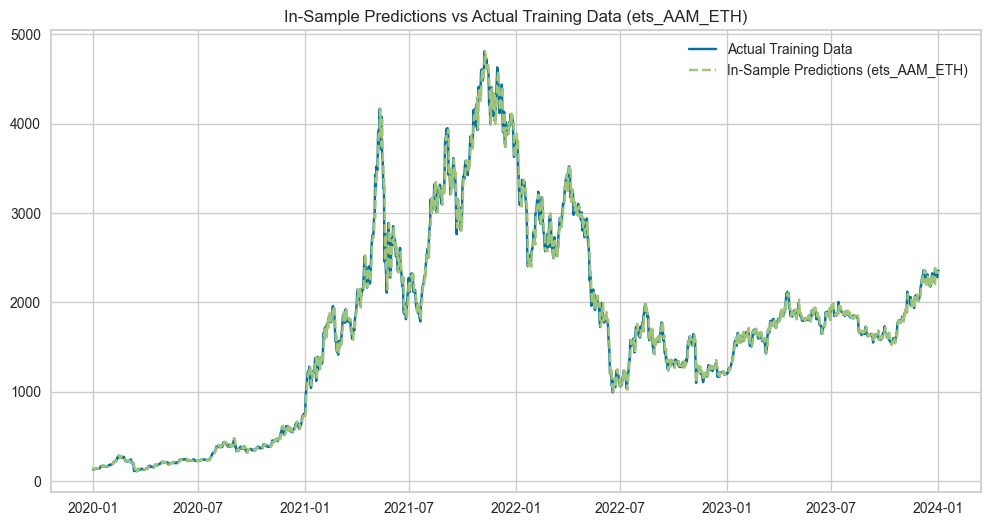

In [ ]:
plt.figure(figsize=(12, 6))
actual_train_index_dt = exp_ETH.get_config('y_train').index.to_timestamp()
prediction_index_dt = in_sample_predictions_ets_AAM_ETH.index.to_timestamp()

plt.plot(actual_train_index_dt, exp_ETH.get_config('y_train'), label='Actual Training Data')
plt.plot(prediction_index_dt, in_sample_predictions_ets_AAM_ETH, label='In-Sample Predictions (ets_AAM_ETH)', linestyle='--')
plt.title('In-Sample Predictions vs Actual Training Data (ets_AAM_ETH)')
plt.legend()
plt.show()

Calculate residuals

In [88]:
# Calculate residuals: actual - predictions
residuals = train_data_ETH - in_sample_predictions_ets_AAM_ETH

# Print the first few residuals
print("\nFirst 10 residuals:")
print(residuals.head(10))



First 10 residuals:
Date
2020-01-01   -24.238314
2020-01-02    -5.281440
2020-01-03     6.141687
2020-01-04    -0.952720
2020-01-05    -1.570831
2020-01-06     3.997900
2020-01-07    -2.540860
2020-01-08    -5.300084
2020-01-09    -3.650948
2020-01-10     4.744073
Freq: D, dtype: float64


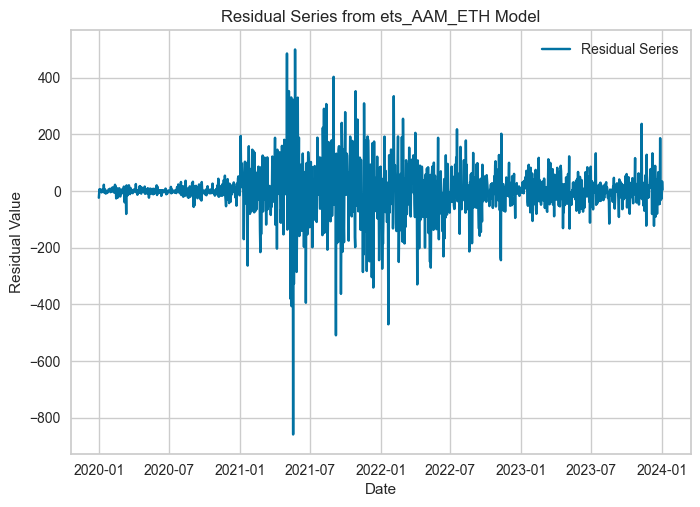

In [89]:
# Convert PeriodIndex to DatetimeIndex for plotting - RESIDUALS INDEX
residuals_index_dt = residuals.index.to_timestamp()

plt.plot(residuals_index_dt, residuals, label='Residual Series')
plt.title('Residual Series from ets_AAM_ETH Model')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

In [ ]:
# Step 8: Perform Lag Selection using ACF on Residual Series
exp_ETH.plot_model(plot='acf',  data_kwargs={'nlags': 50})


Normalize Residual Series (Min-Max Normalization)

In [ ]:
scaler_residuals = MinMaxScaler(feature_range=(-1, 1))
normalized_residuals = scaler_residuals.fit_transform(residuals.values.reshape(-1, 1))
normalized_residuals = pd.Series(normalized_residuals.flatten(), index=residuals.index)
print("\nFirst 10 Normalized Residuals:")
print(normalized_residuals.head(10))


First 10 Normalized Residuals:
Date
2020-01-01    0.229804
2020-01-02    0.257703
2020-01-03    0.274515
2020-01-04    0.264074
2020-01-05    0.263164
2020-01-06    0.271360
2020-01-07    0.261737
2020-01-08    0.257676
2020-01-09    0.260103
2020-01-10    0.272458
Freq: D, dtype: float64


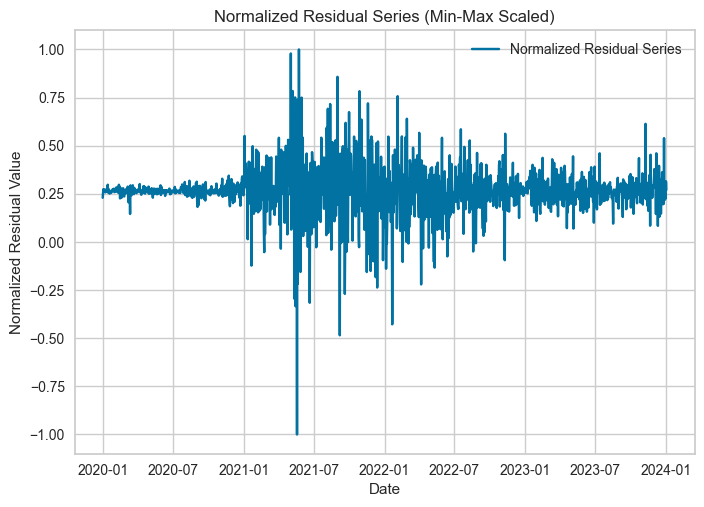

In [ ]:
# Convert PeriodIndex to DatetimeIndex for plotting; normalized residual index  
normalized_residuals_index_dt = normalized_residuals.index.to_timestamp()

plt.plot(normalized_residuals_index_dt, normalized_residuals, label='Normalized Residual Series')
plt.title('Normalized Residual Series (Min-Max Scaled)')
plt.xlabel('Date')
plt.ylabel('Normalized Residual Value')
plt.legend()
plt.show()


In [ ]:
normalized_residuals.fillna(0, inplace=True) 


Prepare Data for ANN - Create Lagged Features and Target

In [ ]:
def create_lagged_features(series, lags):

    lagged_features = {}
    for lag in lags:
        lagged_features[f'lag_{lag}'] = series.shift(lag)
    lagged_df = pd.DataFrame(lagged_features)
    return lagged_df 

lags_to_use = [1, 7, 30]  

lagged_residual_features = create_lagged_features(normalized_residuals, lags_to_use)
lagged_residual_features.dropna(inplace=True) 

residual_target = normalized_residuals.reindex(lagged_residual_features.index)

X_train_ann = lagged_residual_features
y_train_ann = residual_target

X_train_ann_np = X_train_ann.values
y_train_ann_np = y_train_ann.values

Data Splitting for Validation

In [ ]:
from sklearn.model_selection import train_test_split
X_train_ann_train, X_val_ann, y_train_ann_train, y_val_ann = train_test_split(
    X_train_ann, y_train_ann, test_size=0.2, shuffle=False
)

X_val_ann_np = X_val_ann.values 
y_val_ann_np = y_val_ann.values 
X_train_ann_train_np = X_train_ann_train.values  
y_train_ann_train_np = y_train_ann_train.values 

# Ensuring Data Types are float32 
X_train_ann_train_np = X_train_ann_train_np.astype(np.float32)
X_val_ann_np = X_val_ann_np.astype(np.float32) 
y_train_ann_train_np = y_train_ann_train_np.astype(np.float32) 
y_val_ann_np = y_val_ann_np.astype(np.float32) 

Manual Tuning Loop Code 

In [ ]:
neuron_options = [25, 50, 100]
epochs_options = [30, 50, 70]
batch_size_options = [16, 32, 64]

best_rmse = float('inf') 
best_params = None

for neurons in neuron_options:
    for epochs in epochs_options:
        for batch_size in batch_size_options:
            print(f"Trying: Neurons={neurons}, Epochs={epochs}, Batch Size={batch_size}")
            
            # Building ANN model 
            ann_model = Sequential()
            ann_model.add(Dense(neurons, activation='relu', input_shape=(X_train_ann_train_np.shape[1],))) 
            ann_model.add(Dense(25, activation='relu'))
            ann_model.add(Dense(1))
            ann_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse') 
            
            # Train model 
            ann_model.fit(X_train_ann_train_np, y_train_ann_train_np, epochs=epochs, batch_size=batch_size, verbose=0)
            
            print(f"NaNs in X_val_ann_np BEFORE prediction: {np.isnan(X_val_ann_np).any()}")

            # Evaluating on VALIDATION set
            validation_predictions = ann_model.predict(X_val_ann_np).flatten() 
            rmse = np.sqrt(mean_squared_error(y_val_ann_np, validation_predictions)) 

            print(f"  Validation RMSE: {rmse:.4f}")

            if rmse < best_rmse: 
                best_rmse = rmse
                best_params = {'neurons': neurons, 'epochs': epochs, 'batch_size': batch_size}

print("\nBest Hyperparameters found (based on Validation RMSE):")
print(best_params)
print(f"Best Validation RMSE: {best_rmse:.4f}")

Trying: Neurons=25, Epochs=30, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 347us/step


  Validation RMSE: 0.2810
Trying: Neurons=25, Epochs=30, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 369us/step


  Validation RMSE: 0.2866
Trying: Neurons=25, Epochs=30, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 593us/step


  Validation RMSE: 0.2725
Trying: Neurons=25, Epochs=50, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 403us/step


  Validation RMSE: 0.3421
Trying: Neurons=25, Epochs=50, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 366us/step


  Validation RMSE: 0.3007
Trying: Neurons=25, Epochs=50, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 384us/step


  Validation RMSE: 0.3150
Trying: Neurons=25, Epochs=70, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 397us/step


  Validation RMSE: 0.4785
Trying: Neurons=25, Epochs=70, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 345us/step


  Validation RMSE: 0.2975
Trying: Neurons=25, Epochs=70, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 366us/step


  Validation RMSE: 0.3132
Trying: Neurons=50, Epochs=30, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 387us/step


  Validation RMSE: 0.2488
Trying: Neurons=50, Epochs=30, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 385us/step


  Validation RMSE: 0.2385
Trying: Neurons=50, Epochs=30, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 404us/step


  Validation RMSE: 0.2666
Trying: Neurons=50, Epochs=50, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 390us/step


  Validation RMSE: 0.3043
Trying: Neurons=50, Epochs=50, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 447us/step


  Validation RMSE: 0.3185
Trying: Neurons=50, Epochs=50, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 500us/step


  Validation RMSE: 0.3351
Trying: Neurons=50, Epochs=70, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 352us/step


  Validation RMSE: 0.3952
Trying: Neurons=50, Epochs=70, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 416us/step


  Validation RMSE: 0.3847
Trying: Neurons=50, Epochs=70, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 427us/step


  Validation RMSE: 0.3852
Trying: Neurons=100, Epochs=30, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 469us/step


  Validation RMSE: 0.3132
Trying: Neurons=100, Epochs=30, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 448us/step


  Validation RMSE: 0.3274
Trying: Neurons=100, Epochs=30, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 428us/step


  Validation RMSE: 0.3100
Trying: Neurons=100, Epochs=50, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 393us/step


  Validation RMSE: 0.4757
Trying: Neurons=100, Epochs=50, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 457us/step
  Validation RMSE: 0.4007
Trying: Neurons=100, Epochs=50, Batch Size=64


NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 3ms/step


  Validation RMSE: 0.2969
Trying: Neurons=100, Epochs=70, Batch Size=16
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 548us/step


  Validation RMSE: 0.5104
Trying: Neurons=100, Epochs=70, Batch Size=32
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 503us/step


  Validation RMSE: 0.3892
Trying: Neurons=100, Epochs=70, Batch Size=64
NaNs in X_val_ann_np BEFORE prediction: False
12/12 [==============================] - 0s 500us/step
  Validation RMSE: 0.3607

Best Hyperparameters found (based on Validation RMSE):
{'neurons': 50, 'epochs': 30, 'batch_size': 32}
Best Validation RMSE: 0.2385


In [ ]:
# Best Hyperparameters from Tuning 
best_neurons = 50
best_epochs = 30
best_batch_size = 32

# 1. Building the Final ANN Model with Best Hyperparameters
final_ann_model = Sequential()
final_ann_model.add(Dense(best_neurons, activation='relu', input_shape=(X_train_ann_np.shape[1],)))  
final_ann_model.add(Dense(25, activation='relu')) 
final_ann_model.add(Dense(1))

# 2. Compile the Final ANN Model
optimizer = Adam(learning_rate=0.001) 
final_ann_model.compile(optimizer=optimizer, loss='mse')

# 3. Train the Final ANN Model (on FULL training data: X_train_ann_np, y_train_ann_np)
final_ann_model.fit(X_train_ann_np, y_train_ann_np, epochs=best_epochs, batch_size=best_batch_size, verbose=0)   

# 4. Print Model Summary of the Final Model
final_ann_model.summary()

print("\nFinal ANN Model Retraining Complete (with Best Hyperparameters)!")

Model: "sequential_282"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_846 (Dense)           (None, 50)                200       
                                                                 
 dense_847 (Dense)           (None, 25)                1275      
                                                                 
 dense_848 (Dense)           (None, 1)                 26        
                                                                 
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________

Final ANN Model Retraining Complete (with Best Hyperparameters)!


Obtain In-Sample ANN Residual Predictions


First 10 De-normalized In-Sample ANN Residual Predictions:
Date
2020-01-31   -4.211329
2020-02-01   -7.113199
2020-02-02   -7.124863
2020-02-03   -6.916001
2020-02-04   -7.190757
2020-02-05   -7.235268
2020-02-06   -6.462029
2020-02-07   -6.164573
2020-02-08   -6.290044
2020-02-09   -7.244785
Freq: D, dtype: float32


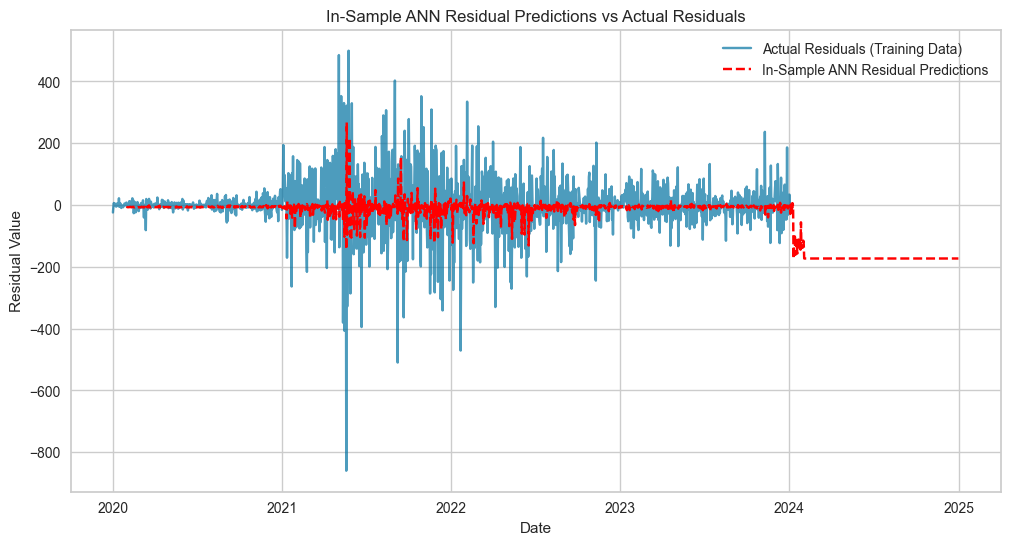

In [ ]:
# Using the trained final_ann_model to predict in-sample residuals

# 2. Generate In-Sample ANN Residual Predictions (Normalized)
ann_predictions_insample_normalized = final_ann_model.predict(X_train_ann_np, verbose=0).flatten()
ann_predictions_insample_normalized = pd.Series(ann_predictions_insample_normalized, index=X_train_ann.index)

# 3. De-normalize ANN Predictions (back to original residual scale)
ann_predictions_insample_denormalized = scaler_residuals.inverse_transform(ann_predictions_insample_normalized.values.reshape(-1, 1)).flatten()
ann_predictions_insample_denormalized = pd.Series(ann_predictions_insample_denormalized, index=ann_predictions_insample_normalized.index)

# 4. Print a sample of de-normalized in-sample ANN predictions
print("\nFirst 10 De-normalized In-Sample ANN Residual Predictions:")
print(ann_predictions_insample_denormalized.head(10))

# 5. Plotting In-Sample ANN Residual Predictions vs Actual Residuals 
plt.figure(figsize=(12, 6))
plt.plot(residuals.index.to_timestamp(), residuals, label='Actual Residuals (Training Data)', alpha=0.7) 
plt.plot(ann_predictions_insample_denormalized.index.to_timestamp(), ann_predictions_insample_denormalized, label='In-Sample ANN Residual Predictions', linestyle='--', color='red') 
plt.title('In-Sample ANN Residual Predictions vs Actual Residuals')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.show()

Obtain Hold-out (Test Set) ANN Residual Predictions

In [ ]:
# 1. Prepare for Iterative Forecast - Get last training residuals as initial history
last_train_residuals_normalized = normalized_residuals.tail(max(lags_to_use)).values 
ann_predictions_holdout_normalized = [] 
current_residuals_history = list(last_train_residuals_normalized) 

# 2. Iterative forecast loop for each step in forecast horizon (fh)
forecast_horizon = len(exp_ETH.get_config('y_test')) 

for _ in range(forecast_horizon): 
    
    # a. Creating feature vector from current residual history
    feature_vector = np.array([current_residuals_history[-lag] for lag in lags_to_use]).reshape(1, -1) # acquire lagged residuals
    
    # b. Predict next residual (normalized) using trained ANN model
    next_residual_normalized = final_ann_model.predict(feature_vector, verbose=0).flatten()[0] 
    ann_predictions_holdout_normalized.append(next_residual_normalized) 
    
    # c. Update residual history for next iteration - append predicted residual and remove oldest
    current_residuals_history.append(next_residual_normalized) 
    current_residuals_history.pop(0) 

# 3. Convert ANN Hold-out Predictions to Pandas Series with Test Set Index
ann_predictions_holdout_normalized = pd.Series(ann_predictions_holdout_normalized, index=exp_ETH.get_config('y_test').index)

# 4. De-normalize ANN Hold-out Predictions 
ann_predictions_holdout_denormalized = scaler_residuals.inverse_transform(np.array(ann_predictions_holdout_normalized).reshape(-1, 1)).flatten()
ann_predictions_holdout_denormalized = pd.Series(ann_predictions_holdout_denormalized, index=ann_predictions_holdout_normalized.index)

# 5. Print sample of de-normalized hold-out ANN residual predictions
print("\nFirst 10 De-normalized Hold-out ANN Residual Predictions:")
print(ann_predictions_holdout_denormalized.head(10))

# Obtain ETS Hold-out Predictions 
ets_predictions_holdout = exp_ETH.predict_model(ets_AAM_ETH)

# Ensuring the index of ETS hold-out predictions is a DatetimeIndex for plotting
if isinstance(ets_predictions_holdout.index, pd.PeriodIndex):
    ets_predictions_holdout.index = ets_predictions_holdout.index.to_timestamp()



First 10 De-normalized Hold-out ANN Residual Predictions:
Date
2024-01-03   -173.179977
2024-01-04   -173.229034
2024-01-05   -173.241623
2024-01-06   -173.244812
2024-01-07   -173.245651
2024-01-08   -173.245865
2024-01-09   -173.245911
2024-01-10   -178.836838
2024-01-11   -179.319946
2024-01-12   -179.324310
Freq: D, dtype: float32


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ETS,1.7452,1.4016,531.6968,637.6510,0.1639,0.1785,-0.5789


In [ ]:
# Print summary statistics (min, max, mean, std) for actual test residuals
y_test_ETH_datetime_index = y_test_ETH.copy() 
y_test_ETH_datetime_index.index = y_test_ETH_datetime_index.index.to_timestamp() 

actual_test_residuals_series = y_test_ETH_datetime_index - ets_predictions_holdout['y_pred']

print("\nSummary Statistics - Actual Test Set Residuals (DatetimeIndex):")
print(actual_test_residuals_series.describe())

# Print summary statistics for de-normalized ANN hold-out predictions 
print("\nSummary Statistics - De-normalized ANN Hold-out Predictions:")
print(ann_predictions_holdout_denormalized.describe())


Summary Statistics - Actual Test Set Residuals (DatetimeIndex):
count     365.000000
mean      355.325720
std       530.200558
min      -531.958218
25%      -125.316257
50%       372.340679
75%       794.500450
max      1593.943768
dtype: float64

Summary Statistics - De-normalized ANN Hold-out Predictions:
count    365.000000
mean    -177.493393
std        2.077432
min     -180.219406
25%     -179.577393
50%     -177.814499
75%     -175.288498
max     -173.179977
dtype: float64


In [115]:
print("\nHead of ets_predictions_holdout DataFrame:")
print(ets_predictions_holdout.head())
print("\nInfo of ets_predictions_holdout DataFrame:")
ets_predictions_holdout.info()


Head of ets_predictions_holdout DataFrame:
               y_pred
2024-01-03  2375.6751
2024-01-04  2368.4690
2024-01-05  2342.1619
2024-01-06  2347.0460
2024-01-07  2363.1619

Info of ets_predictions_holdout DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2024-01-03 to 2025-01-01
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y_pred  365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [116]:
print("\nHead of y_test_ETH DataFrame:")
print(y_test_ETH.head())
print("\nInfo of y_test_ETH DataFrame:")
y_test_ETH.info()



Head of y_test_ETH DataFrame:
Date
2024-01-03    2210.761963
2024-01-04    2269.038086
2024-01-05    2268.647217
2024-01-06    2241.624756
2024-01-07    2222.865967
Freq: D, Name: Close, dtype: float64

Info of y_test_ETH DataFrame:
<class 'pandas.core.series.Series'>
PeriodIndex: 365 entries, 2024-01-03 to 2025-01-01
Freq: D
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [ ]:
# Re-run to Obtain Hold-out (Test Set) Predictions from Best ETS Model
ets_predictions_holdout = exp_ETH.predict_model(ets_AAM_ETH) 

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ETS,1.7452,1.4016,531.6968,637.6510,0.1639,0.1785,-0.5789


In [118]:
# Calculate residuals: actual - predictions
residuals = train_data_ETH - in_sample_predictions_ets_AAM_ETH


Combine ETS and ANN Predictions for Final Hybrid Forecasts

In [ ]:
# Get ETS hold-out predictions 
ets_predictions_holdout = exp_ETH.predict_model(ets_AAM_ETH)

# Combine ETS predictions and ANN residual predictions for final hybrid hold-out forecasts
final_predictions_holdout_hybrid = ets_predictions_holdout['y_pred'] + ann_predictions_holdout_denormalized

print("\nFirst 10 Final Hybrid Hold-out Forecasts:")
print(final_predictions_holdout_hybrid.head(10))

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ETS,1.7452,1.4016,531.6968,637.6510,0.1639,0.1785,-0.5789



First 10 Final Hybrid Hold-out Forecasts:
2024-01-03    2202.495123
2024-01-04    2195.239966
2024-01-05    2168.920277
2024-01-06    2173.801188
2024-01-07    2189.916249
2024-01-08    2185.381935
2024-01-09    2157.818389
2024-01-10    2214.092562
2024-01-11    2179.223954
2024-01-12    2173.129790
Freq: D, dtype: float64


In [120]:
def ts_metrics(y, y_hat):

    mae = mean_absolute_error(y, y_hat)
    mape = mean_absolute_percentage_error(y, y_hat)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    r2 = r2_score(y, y_hat)
    
    metrics = {
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse,
        'R2': r2,
    }
    
    print("Time Series Model Evaluation Metrics:")
    print("-" * 40)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.4%}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    
    return 

Evaluate Hybrid Model Performance on Hold-out Set

In [ ]:
print("\n--- Hybrid Model Evaluation Metrics (Hold-out Set) ---")
ts_metrics(exp_ETH.get_config('y_test'), final_predictions_holdout_hybrid) 


--- Hybrid Model Evaluation Metrics (Hold-out Set) ---
Time Series Model Evaluation Metrics:
----------------------------------------
Mean Absolute Error (MAE): 611.1993
Mean Absolute Percentage Error (MAPE): 18.4138%
Root Mean Squared Error (RMSE): 751.2697
R-squared (R²): -1.1916


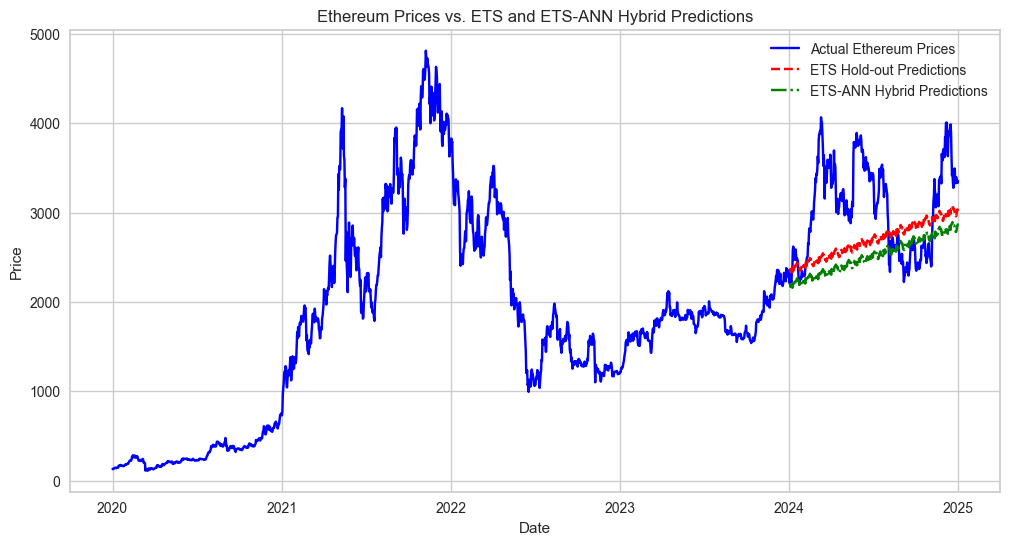

In [ ]:
# Ensuring correct index type for plotting
if isinstance(df_ETH.index, pd.PeriodIndex):
    df_ETH.index = df_ETH.index.to_timestamp()

if isinstance(ets_predictions_holdout.index, pd.PeriodIndex):
    ets_predictions_holdout.index = ets_predictions_holdout.index.to_timestamp()

# Ensure df_ETH is a DataFrame and contains the 'Close' column
if isinstance(df_ETH, pd.Series):
    df_ETH = df_ETH.to_frame(name='Close')

plt.figure(figsize=(12, 6))

# Plot Actual Ethereum Prices (Full Data)
if isinstance(df_ETH, pd.DataFrame) and 'Close' in df_ETH.columns:
    plt.plot(df_ETH.index, df_ETH['Close'], label='Actual Ethereum Prices', color='blue')
else:
    print("Error: 'Close' column not found in df_ETH DataFrame")

# Plot ETS Hold-out Predictions
if isinstance(ets_predictions_holdout, pd.DataFrame) and 'y_pred' in ets_predictions_holdout.columns:
    plt.plot(ets_predictions_holdout.index, ets_predictions_holdout['y_pred'], label='ETS Hold-out Predictions', color='red', linestyle='--')
else:
    print("Error: 'y_pred' column not found in ets_predictions_holdout DataFrame")

# Plot ETS-ANN Hybrid Predictions
if isinstance(final_predictions_holdout_hybrid, pd.Series):
    plt.plot(final_predictions_holdout_hybrid.index, final_predictions_holdout_hybrid, label='ETS-ANN Hybrid Predictions', color='green', linestyle='-.')
else:
    print("Error: final_predictions_holdout_hybrid is not a Series")

plt.title('Ethereum Prices vs. ETS and ETS-ANN Hybrid Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

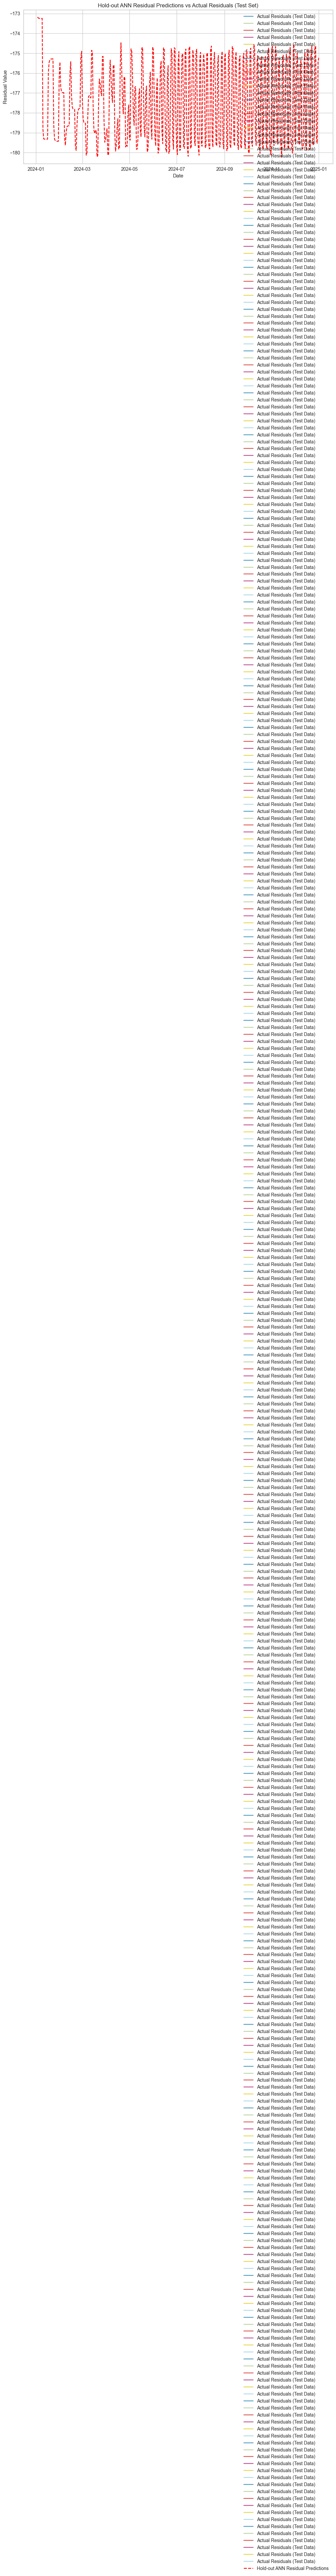

In [ ]:
# 6. Plotting Hold-out ANN Residual Predictions vs Actual Residuals (Test Set)
plt.figure(figsize=(12, 6))
plt.plot(exp_ETH.get_config('y_test').index.to_timestamp(), exp_ETH.get_config('y_test') - ets_predictions_holdout, label='Actual Residuals (Test Data)', alpha=0.7) 
plt.plot(ann_predictions_holdout_denormalized.index.to_timestamp(), ann_predictions_holdout_denormalized, label='Hold-out ANN Residual Predictions', linestyle='--', color='red')  
plt.title('Hold-out ANN Residual Predictions vs Actual Residuals (Test Set)')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()
plt.show()